In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.io import read
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

import numpy as np
from sklearn.decomposition import PCA

/home/ntt203/.conda/envs/raffle_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-12 14:43:14,146	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
## Set up the plotting environment
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('font', family='cmr10', size=12)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [3]:
## Set the plotting parameters
seed = 0
identifier = "_CHGNet"
# min_energy = -

In [4]:
## Set the descriptors
from agox.models.descriptors.fingerprint import Fingerprint
# from agox.models.descriptors import Voronoi

template = read("DTMP"+identifier+"/unrlxd_structures_seed0.traj")
# diamond = bulk("C", "diamond", a=3.567)  # Lattice constant for diamond cubic carbon
confinement_cell = template.cell.copy()
confinement_corner = np.array([0, 0, 0])
environment = Environment(
    template=template,
    symbols="",
    confinement_cell=confinement_cell,
    confinement_corner=confinement_corner,
    box_constraint_pbc=[True, True, True],  # Confinement is periodic in all directions.
)
descriptor = Fingerprint(environment=environment)
# graph_descriptor = Voronoi(
#     covalent_bond_scale_factor=1.3, n_points=8, angle_from_central_atom=20, environment=None
# )


╭───────────────────────────── Environment report ─────────────────────────────╮
│ Atoms in search:                                                             │
│ Template formula: Mo2S4                                                      │
│ Full formula: Mo2S4                                                          │
│ Cell:                                                                        │
│     1.60 -2.76 0.00                                                          │
│     1.60 2.76 0.00                                                           │
│     0.00 0.00 13.10                                                          │
│ Periodicity:                                                                 │
│     True True True                                                           │
│ Box constraint: True                                                         │
│ Confinement corner                                                           │
│     0.00 0.00 0.00                                                           │
│ Confinement cell:                                                            │
│     1.60 -2.76 0.00                                                          │
│     1.60 2.76 0.00                                                           │
│     0.00 0.00 13.10                                                          │
╰──────────────────────────────────────────────────────────────────────────────╯

In [29]:
## Set the calculators
from chgnet.model import CHGNetCalculator
from ase.calculators.singlepoint import SinglePointCalculator
calc = CHGNetCalculator()

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [30]:
## Load the unrelaxed structures
unrlxd_structures = read("DTMP"+identifier+"/unrlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in unrlxd_structures:
  structure.calc = calc

In [31]:
## Load the relaxed structures
rlxd_structures = read("DTMP"+identifier+"/rlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in rlxd_structures:
  structure.calc = calc

In [32]:
## Get MoS2 H-phase and T-phase and attach calculator and calculate energy
H_phase = read("MoS2_H-phase.poscar")
H_phase.set_cell(rlxd_structures[0].get_cell())
H_phase.calc = calc
T_phase = read("MoS2_T-phase.poscar")
T_phase.set_cell(rlxd_structures[0].get_cell())
T_phase.calc = calc
energies_per_atom = [H_phase.get_potential_energy() / len(H_phase), T_phase.get_potential_energy() / len(T_phase)]
min_energy = np.min(energies_per_atom)
print("H/T-phase min energy: ", min_energy)

H/T-phase min energy:  -7.547157


In [33]:
## Read energies from energies_unrlxd_seed0.txt and add to the respective structures using a SinglePointCalculator
## The file has the form "index energy"
## This is done because there seem to be issues with storing the energy in the ASE trajectory file for some setups
filename = "DTMP"+identifier+"/energies_unrlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        unrlxd_structures[index].calc = SinglePointCalculator(unrlxd_structures[index], energy=energy * len(unrlxd_structures[index]))


filename = "DTMP"+identifier+"/energies_rlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        rlxd_structures[index].calc = SinglePointCalculator(rlxd_structures[index], energy=energy * len(rlxd_structures[index]))

In [34]:
## Calculate energies per atom for each unrelaxed structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in unrlxd_structures]
unrlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Unrelaxed min energy: ", np.min(energies_per_atom))

Unrelaxed min energy:  -7.541717052459717


In [35]:
## Calculate energies per atom for each relaxed structure
energies_per_atom = [structure.get_potential_energy() / len(structure) for structure in rlxd_structures]
rlxd_delta_en_per_atom = np.array(energies_per_atom) - min_energy
print("Relaxed min energy: ", np.min(energies_per_atom))

Relaxed min energy:  -7.5485615730285645


In [36]:
print("H-phase cell:", read("MoS2_H-phase.poscar").get_cell())
print("T-phase cell:", read("MoS2_T-phase.poscar").get_cell())
print("Unrelaxed cell:", unrlxd_structures[0].get_cell())
print("Relaxed cell:", rlxd_structures[0].get_cell())

H-phase cell: Cell([[1.592716, -2.758665, 0.0], [1.592716, 2.758665, 0.0], [0.0, 0.0, 13.17839]])
T-phase cell: Cell([[1.592716, -2.758665, 0.0], [1.592716, 2.758665, 0.0], [0.0, 0.0, 12.62495]])
Unrelaxed cell: Cell([[1.5950000286102295, -2.7626209259033203, 0.0], [1.5950000286102295, 2.7626209259033203, 0.0], [0.0, 0.0, 13.100000381469727]])
Relaxed cell: Cell([[1.5950000286102295, -2.7626209259033203, 0.0], [1.5950000286102295, 2.7626209259033203, 0.0], [0.0, 0.0, 13.100000381469727]])


In [37]:
if abs( np.min(energies_per_atom) - min_energy ) > 5e-2:
  print("Minimum energy per atom is not zero. Check the energy calculation.")

In [38]:
## Set up the PCA
pca = PCA(n_components=2)

In [39]:
## Fit the PCA model to the unrelaxed or relaxed structures
rlxd_string = "rlxd"

In [40]:
## Save pca model
import pickle
if False:
  # pca.fit(np.squeeze([arr for arr in descriptor.get_features(unrlxd_structures + [H_phase, T_phase])]))
  # with open("pca_model"+identifier+"_all_unrlxd_"+str(seed)+".pkl", "wb") as f:
  pca.fit(np.squeeze([arr for arr in descriptor.get_features(unrlxd_structures + [H_phase] + [T_phase])]))
  with open("pca_model"+identifier+"_all_unrlxd_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

## Load pca model
with open("pca_model_all_"+rlxd_string+"_0.pkl", "rb") as f:
  pca = pickle.load(f)

In [41]:
## Transform the unrelaxed and relaxed structures to the reduced space
unrlxd_X_reduced = pca.transform(np.squeeze([arr for arr in descriptor.get_features(unrlxd_structures)]))
rlxd_X_reduced = pca.transform(np.squeeze([arr for arr in descriptor.get_features(rlxd_structures)])) # + [H_phase] + [T_phase])]))
H_phase_X_reduced = pca.transform(descriptor.get_features(H_phase))
T_phase_X_reduced = pca.transform(descriptor.get_features(T_phase))

In [42]:
## Get the index of the structure with the minimum energy
min_energy_index = np.argmin(rlxd_delta_en_per_atom)
print(min_energy_index)

837


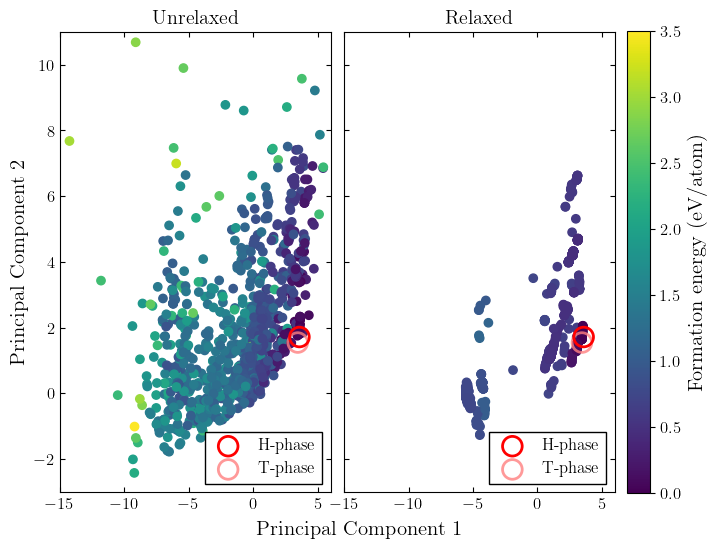

In [43]:
## Plot the PCA
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

plt.subplots_adjust(wspace=0.05, hspace=0)

## Get the maximum energy for the colourbar
max_en = min(3.5, max(np.max(unrlxd_delta_en_per_atom), np.max(rlxd_delta_en_per_atom)))

## Plot the PCA
axes[0].scatter(unrlxd_X_reduced[:, 0], unrlxd_X_reduced[:, 1], c=unrlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)
axes[1].scatter(rlxd_X_reduced[:, 0], rlxd_X_reduced[:, 1], c=rlxd_delta_en_per_atom, cmap="viridis", vmin = 0, vmax = max_en)

## Add the minimum energy structures to the plot
for ax in axes:
    ax.scatter(T_phase_X_reduced[0,0], T_phase_X_reduced[0,1], s=200, edgecolor=[1.0, 0.5, 0.5, 0.8], facecolor='none', linewidth=2, label='T-phase')
    ax.scatter(H_phase_X_reduced[0,0], H_phase_X_reduced[0,1], s=200, edgecolor='red', facecolor='none', linewidth=2, label='H-phase')
    ax.legend(fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], facecolor='white', framealpha=1.0, edgecolor='black', fancybox=False, loc='lower right')

## Add labels
fig.text(0.5, 0.04, 'Principal Component 1', ha='center', fontsize=15)
axes[0].set_ylabel('Principal Component 2', fontsize=15)
axes[0].set_title('Unrelaxed')
axes[1].set_title('Relaxed')
if identifier == "_VASP":
  if rlxd_string == "rlxd":
    xlims = [-11, 8]
    ylims = [-5, 6]
  else:
    xlims = [-9, 13]
    ylims = [-7, 12]
else:
  if rlxd_string == "rlxd":
    xlims = [-15, 6]
    ylims = [-3, 11]
  else:
    xlims = [-10, 39]
    ylims = [-3, 30]

for ax in axes:
  ax.tick_params(axis='both', direction='in')
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)

## Unify tick labels
xticks = axes[0].get_xticks()
xticks = xticks[(xticks >= xlims[0]) & (xticks <= xlims[1])]
xticklabels = [ text for text in axes[0].get_xticklabels() if float(text.get_position()[0]) >= xlims[0] and float(text.get_position()[0]) <= xlims[1] ]
axes[0].set_xticks(xticks)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticklabels)
axes[1].set_yticklabels([])
axes[0].tick_params(axis='x', labelbottom=True, top=True)
axes[1].tick_params(axis='x', labelbottom=True, top=True)
axes[0].tick_params(axis='y', labelbottom=True, right=True)
axes[1].tick_params(axis='y', labelbottom=True, right=True)

## Make axes[0] and axes[1] the same width
axes[0].set_box_aspect(1.7)
axes[1].set_box_aspect(1.7)

## Add colorbar next to the axes
cbar = fig.colorbar(axes[1].collections[0], ax=axes, orientation='vertical', fraction=0.085, pad=0.02)
cbar.set_label('Formation energy (eV/atom)', fontsize=15)

## Save the figure
plt.savefig('MoS2_RAFFLE'+identifier+'_pca_'+rlxd_string+'_fit_seed'+str(seed)+'.pdf', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')